In [1]:
%reset -f

In [2]:
import numpy as np
import torchdiffeq
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
from typing import List

In [3]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [4]:
from utils_torch import *

In [5]:
def create_rod_with_nodes_and_edges(num_nodes: int):
    nodes = []
    edges = []
    for i in range(num_nodes):
        nodes.append(np.array([i * 0.1, 0.0, 0.0], dtype=np.float32))
        if i<num_nodes-1:
            edges.append([i, i+1])
    return nodes, edges

def build_rod_springs(nodes):
    num_nodes = len(nodes)

    stretch = []
    bend = []
    d1_init = []
    for j in range(num_nodes - 1):
        d1_init.append(np.array([0.0, 0.0, 1.0]))

    for i in range(num_nodes):
        if i == 0:
            # boundary at left end: stencil (0,1), no right neighbor
            l0 = np.linalg.norm(nodes[i+1] - nodes[i]).astype(np.float32)
            l1 = 0.0
            leff = 0.5 * l0
            stretch.append((i, i+1, -1, True, l0, l1, leff))

        elif i == num_nodes - 1:
            # boundary at right end: stencil (n-2,n-1)
            l0 = np.linalg.norm(nodes[i] - nodes[i-1]).astype(np.float32)
            l1 = 0.0
            leff = 0.5 * l0
            stretch.append((i-1, i, -1, True, l0, l1, leff))

        else:
            # internal node i uses (i-1,i,i+1)
            l0 = np.linalg.norm(nodes[i] - nodes[i-1]).astype(np.float32)
            l1 = np.linalg.norm(nodes[i+1] - nodes[i]).astype(np.float32)
            leff = 0.5 * (l0 + l1)
            stretch.append((i-1, i, i+1, False, l0, l1, leff))
            # bend.append((i-1, i, i+1))
            bend.append((i-1, i, i+1, i-1, i)) # with edge index

    # Convert to torch tensors for class storage
    stretch = np.array(stretch, dtype=object)

    stretch_idx = torch.tensor(stretch[:, 0:3].astype(np.int64))  # (S,3) [i,j,k_raw]
    stretch_is_boundary = torch.tensor(stretch[:, 3].astype(bool))# (S,)
    stretch_l0 = torch.tensor(stretch[:, 4].astype(np.float32))   # (S,)
    stretch_l1 = torch.tensor(stretch[:, 5].astype(np.float32))   # (S,)
    stretch_leff = torch.tensor(stretch[:, 6].astype(np.float32)) # (S,)

    bend_idx = torch.tensor(np.array(bend, dtype=np.int64))       # (Sb,3)

    return bend_idx, stretch_idx, stretch_is_boundary, stretch_l0, stretch_l1, stretch_leff, d1_init


In [6]:
def build_initial_state(nodes: List[np.ndarray]) -> np.ndarray:
    """
    q0: stacked node positions (3*num_nodes) plus edge DOFs (num_nodes-1)
    v0: zeros like q0
    x0: concat(q0, v0)
    """
    num_nodes = len(nodes)

    q0_nodes = np.array(nodes, dtype=np.float32).reshape(-1)  # (3*num_nodes,)
    q0_edges = np.zeros(num_nodes - 1, dtype=np.float32)      # (num_nodes-1,)
    q0 = np.concatenate([q0_nodes, q0_edges], axis=0)

    v0 = np.zeros_like(q0, dtype=np.float32)
    x0 = np.concatenate([q0, v0], axis=0)  # (2*ndof,)
    return x0

In [7]:
# --- build a simple rod: 3 DOF per node (x,y,z) ---
num_nodes = 5
nodes, edges  = create_rod_with_nodes_and_edges(num_nodes)  # 11 nodes -> ndof = 33
x0 = build_initial_state(nodes)
q0 = x0[: (x0.size // 2)]
ndof = q0.size

# convert x0 to torch.tensor
x0 = torch.Tensor(x0)
print("Initial positions q0:", q0)
print("Initial state x0:", x0)

# create springs (3 consecutive nodes and effective length)
bend_idx, stretch_idx, stretch_is_boundary, stretch_l0, stretch_l1, stretch_leff, d1_init = build_rod_springs(nodes)

# Material properties
E = 1e7  # Young's modulus
r0 = 0.01  # radius
A = np.pi * r0**2  # cross-sectional area
I = 0.25 * np.pi * r0**4  # area moment of inertia
rho = 1200  # density
mass = rho*A*1  # mass per segment (length 1 m)
m_per_node = mass/num_nodes

EA = E * A  # axial stiffness
EI = E * I  # bending stiffness
stiffness_matrix = torch.tensor([[EA, 0.0],
                                  [0.0, EI]], dtype=torch.float32)
stiffnesses = stiffness_matrix.to(device)

# print("Stretch springs:", stretch_springs)
# print("Bend springs:", bend_springs)
print(f"EA={EA:.3e}, EI={EI:.3e}")


Initial positions q0: [0.  0.  0.  0.1 0.  0.  0.2 0.  0.  0.3 0.  0.  0.4 0.  0.  0.  0.  0.
 0. ]
Initial state x0: tensor([0.0000, 0.0000, 0.0000, 0.1000, 0.0000, 0.0000, 0.2000, 0.0000, 0.0000,
        0.3000, 0.0000, 0.0000, 0.4000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])
EA=3.142e+03, EI=7.854e-02


In [8]:
# from strains_torch import get_strain_stretch2D_torch, get_strain_curvature_3D_torch
from strains_torch_copy import get_strain_stretch2D_torch, get_strain_curvature_3D_torch

from Energy_NN_new import Shared3LinearEnergy

In [9]:
class AnalyticalODE(nn.Module):
    def __init__(self, edges, n_nodes: int, a1_init, q_init,
                 m_per_dof: float = 1.0, c_per_dof: float = 0.1, 
                 g: float = 9.81, freeDOF: List[int]=None, 
                 bend_idx: torch.Tensor = None, stretch_idx: torch.Tensor = None,
                    stretch_is_boundary: torch.Tensor = None,
                    stretch_l0: torch.Tensor = None, stretch_l1: torch.Tensor = None, stretch_leff: torch.Tensor = None,
                 stiffnesses: torch.Tensor = None, energy_nn: Shared3LinearEnergy = None,
                 dtype=torch.float32):
        super().__init__()
        
        self.n_nodes = n_nodes
        self.n_edges = n_nodes-1
        self.ndof = 3*n_nodes + self.n_edges
        self.freeDOF = freeDOF
        self.call_count = 0
        self.register_buffer("edges", torch.as_tensor(edges, dtype=torch.long))
        self.register_buffer("a1_init", a1_init)
        self.register_buffer("q_init", q_init)

        # Indices / masks
        if freeDOF is None:
            freeDOF = list(range(ndof))
        free_idx = torch.as_tensor(freeDOF, dtype=torch.long)
        fixed_mask = torch.ones(ndof, dtype=torch.bool)
        fixed_mask[free_idx] = False
        self.register_buffer("free_idx", free_idx)
        self.register_buffer("fixed_mask", fixed_mask)
        self.register_buffer("free_mask", ~fixed_mask)  # same shape

        # Diagonal mass and damping for now (easy to replace with full matrices later)
        M = torch.eye(ndof) * m_per_dof       # (ndof, ndof)
        C = torch.eye(ndof) * c_per_dof       # (ndof, ndof)

        # Gravity as external force: acts in z only (every 3rd DOF starting from index 2)
        f_ext = torch.zeros(ndof)
        f_ext[2::3] = -m_per_dof * g          # (ndof,)
        # f_ext[0::3] = -m_per_dof * g          # (ndof,) # gravity in x-direction for testing

        # Register as buffers so dtype/device track the module (and no grads)
        self.register_buffer("M", M)
        self.register_buffer("C", C)
        self.register_buffer("f_ext", f_ext)

        # Pre-slice free blocks once (for diagonal M this is overkill but scales)
        self.register_buffer("M_ff", M.index_select(0, free_idx).index_select(1, free_idx))
        self.register_buffer("C_ff", C.index_select(0, free_idx).index_select(1, free_idx))

        # stencils
        self.register_buffer("bend_springs", bend_idx)
        self.register_buffer("stretch_springs", stretch_idx)

        self.register_buffer("stretch_is_boundary", stretch_is_boundary)
        self.register_buffer("stretch_l0", stretch_l0)
        self.register_buffer("stretch_l1", stretch_l1)
        self.register_buffer("stretch_leff", stretch_leff)

        # stiffnesses
        self.register_buffer("stiffnesses", stiffnesses)
        self.register_buffer("EA", stiffnesses[0,0])
        self.register_buffer("EI", stiffnesses[1,1])
        self.energy_nn = energy_nn
    
    @staticmethod
    def _broadcast_1d_to_batch(x_1d: torch.Tensor, q: torch.Tensor) -> torch.Tensor:
        batch_ones = [1] * (q.dim() - 1)
        return x_1d.view(*batch_ones, -1)

    def elastic_force(
        self,
        q: torch.Tensor,
        m1: torch.Tensor,
        m2: torch.Tensor,
        refTwist: torch.Tensor=None,
        *,
        detach_frames: bool = True,
    ) -> torch.Tensor:
        device = q.device

        # don’t detach if you want upstream gradients
        q_in = q if q.requires_grad else q.requires_grad_(True)
        q_nodes = q_in.view(*q_in.shape[:-1], -1, 3)  # (..., n_nodes, 3)

        if detach_frames:
            m1 = m1.detach()
            m2 = m2.detach()

        # --------------------------
        # Stretch eps: (..., S)
        # --------------------------
        springs = self.stretch_springs.to(device)
        is_boundary = self.stretch_is_boundary.to(device)
        l0 = self.stretch_l0.to(device)
        l1 = self.stretch_l1.to(device)

        i = springs[:, 0].long()
        j = springs[:, 1].long()
        k_raw = springs[:, 2].long()
        k_safe = k_raw.clamp_min(0)

        node0 = q_nodes.index_select(-2, i)
        node1 = q_nodes.index_select(-2, j)
        node2 = q_nodes.index_select(-2, k_safe)

        isb = self._broadcast_1d_to_batch(is_boundary, q_in)
        l0b = self._broadcast_1d_to_batch(l0, q_in)
        l1b = self._broadcast_1d_to_batch(l1, q_in)

        eps = get_strain_stretch2D_torch(node0, node1, node2, l0b, l1b, isb)  # (..., S)

        # --------------------------
        # Bend kappa1,kappa2: (..., Sb)
        # --------------------------
        bspr = self.bend_springs.to(device)
        i = bspr[:, 0].long()
        j = bspr[:, 1].long()
        k = bspr[:, 2].long()
        edge_e_id = bspr[:, 3].long()
        edge_f_id = bspr[:, 4].long()

        node0 = q_nodes.index_select(-2, i)
        node1 = q_nodes.index_select(-2, j)
        node2 = q_nodes.index_select(-2, k)

        m1_e = m1.index_select(-2, edge_e_id)
        m1_f = m1.index_select(-2, edge_f_id)
        m2_e = m2.index_select(-2, edge_e_id)
        m2_f = m2.index_select(-2, edge_f_id)

        kappa1, kappa2 = get_strain_curvature_3D_torch(
            node0, node1, node2, m1_e, m2_e, m1_f, m2_f
        )  # (..., Sb), (..., Sb)

        # --------------------------
        # Total energy from shared 3 params
        # --------------------------
        E_total = self.energy_nn(eps, kappa1, kappa2)  # (...)

        (dE_dq,) = torch.autograd.grad(E_total, q_in, create_graph=True)
        return -dE_dq
    
    def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        x shape: (..., 2*ndof)
        Returns dx/dt with same shape.
        """
        ndof = self.ndof
        q = x[..., :ndof]        # (..., ndof)
        v = x[..., ndof:]        # (..., ndof)

        thetas = q[..., 3*self.n_nodes:]
        q_nodes = q[..., :3*self.n_nodes]

        thetas = torch.zeros_like(thetas)  # for testing zero twist

        # compute tangents
        tangents = compute_tangent(q_nodes, self.edges)

        # Compute time parallel
        q_init_nodes = self.q_init[:3*self.n_nodes]
        a1, a2 = compute_time_parallel(self.a1_init, q_init_nodes, q_nodes, edges=self.edges)

        m1, m2 = compute_material_directors(thetas, a1, a2)

        reftwist = compute_reference_twist(self.edges, a1, tangents)

        # Forces
        f_el = self.elastic_force(q_nodes, m1, m2, reftwist)          # (..., ndof)
        # pad with zeros for edge DOFs
        f_el_full = torch.zeros_like(q)
        f_el_full[..., :3*self.n_nodes] = f_el
        f_damp = torch.matmul(v, self.C.T)    # (..., ndof)

        # External + elastic + damping
        rhs = -f_damp + f_el_full + self.f_ext     # (..., ndof)
        # Free-DOF solve
        idx = self.free_idx
        rhs_f = rhs.index_select(-1, idx)     # (..., n_free)
        v_f   = v.index_select(-1, idx)       # (..., n_free)

        M_ff = self.M_ff
        a_f = torch.linalg.solve(M_ff, rhs_f.unsqueeze(-1)).squeeze(-1)  # (..., n_free)

        # Scatter back to full
        a_full = torch.zeros_like(v)
        v_full = torch.zeros_like(v)
        a_full[..., idx] = a_f
        v_full[..., idx] = v_f

        dxdt = torch.cat([v_full, a_full], dim=-1)

        # Logging
        self.call_count += 1
        if self.call_count % 1000 == 0:
            ke = 0.5 * torch.sum(v_full**2)
            print(f"[{self.call_count}] t={t.item():.3f}, KE={ke.item():.3e}")

        return dxdt


In [10]:
bend_idx = torch.as_tensor(bend_idx, dtype=torch.int64, device=device)
stretch_idx = torch.as_tensor(stretch_idx, dtype=torch.int64, device=device)
stretch_is_boundary = torch.as_tensor(stretch_is_boundary, dtype=torch.bool, device=device)

stretch_l0 = torch.as_tensor(stretch_l0, dtype=torch.float32, device=device)
stretch_l1 = torch.as_tensor(stretch_l1, dtype=torch.float32, device=device)
stretch_leff = torch.as_tensor(stretch_leff, dtype=torch.float32, device=device)

stiffnesses = torch.as_tensor(stiffnesses, dtype=torch.float32, device=device)
edges_t = torch.as_tensor(edges, dtype=torch.int64, device=device)
q_init = torch.as_tensor(q0, dtype=torch.float32, device=device)
d1_init_np = np.asarray(d1_init, dtype=np.float32)      # or np.stack(d1_init).astype(np.float32)
a1_init = torch.from_numpy(d1_init_np).to(dtype=torch.float32, device=device)

In [11]:
# --- stretch ---
leff_bar = stretch_leff.mean()

k_eps_0 = EA * leff_bar

# --- bend ---
k_kappa_0 = EI / leff_bar
# pack initial guesses
weights = torch.tensor(
    [k_eps_0, k_kappa_0, k_kappa_0],
    dtype=torch.float32
)

# energy_nn = Shared3LinearEnergy(weights=weights)
energy_nn = Shared3LinearEnergy()

In [12]:
# # --- set up and integrate ---
ndof = q0.size
freeDOF = list(range(6, 3*num_nodes))  # fix first two nodes (first 6 DOF)
odefunc = AnalyticalODE(edges=edges_t,
                   n_nodes=num_nodes,
                   a1_init = a1_init,
                   q_init = q_init,
                  m_per_dof=m_per_node,
                  c_per_dof=0.1,
                  g=9.81,
                  freeDOF=freeDOF,
                  bend_idx=bend_idx, 
                  stretch_idx=stretch_idx,
                  stretch_is_boundary=stretch_is_boundary,
                  stretch_l0=stretch_l0, stretch_l1=stretch_l1, stretch_leff=stretch_leff,
                  stiffnesses=stiffnesses,
                  energy_nn = energy_nn,
                  dtype=torch.float32).to(device)

optimizer = optim.Adam(odefunc.energy_nn.parameters(), lr=1e-3)

In [13]:
def trajectory_loss(student, x0, t_eval, x_ref_traj,
                    weight_q=1.0, weight_v=1.0
                    ):
    """
    x0: (2*ndof,)
    t_eval: (T,)
    x_ref_traj: (T, 2*ndof)
    """

    x_pred = odeint(
        student, x0, t_eval,
        method='dopri5',
        rtol=1e-3,
        atol=1e-3,
        options={'max_num_steps': 10000}
    )  # (T, 2*ndof)

    ndof = x0.numel() // 2

    q_pred = x_pred[..., :ndof]
    v_pred = x_pred[..., ndof:]
    q_ref  = x_ref_traj[..., :ndof]
    v_ref  = x_ref_traj[..., ndof:]

    loss_q = torch.mean((q_pred - q_ref)**2)
    loss_v = torch.mean((v_pred - v_ref)**2)
    return weight_q * loss_q + weight_v * loss_v

In [14]:
# read ref trajectory from file
x_ref = torch.load("analytical_beam_trajectory.pt", map_location=device).to(device)


In [15]:
dtype=torch.float32


n_epochs = 100
T = 0.5
dt = 0.001
steps = int(T/dt) + 1
t = torch.linspace(0., T, steps, dtype=dtype)

# Now move all inputs / reference data
x0    = x0.to(device=device, dtype=dtype)
t     = t.to(device=device, dtype=dtype)
# x_ref = x_ref.to(device=device, dtype=dtype)
# use only the part of x_ref that corresponds to t
x_ref = x_ref[:steps].to(device=device, dtype=dtype)

print("model param device:", next(odefunc.parameters()).device)
print("x0 device:", x0.device)
print("t device:", t.device)
print("x_ref device:", x_ref.device)

model param device: cpu
x0 device: cpu
t device: cpu
x_ref device: cpu


In [16]:
# --- training loop ---
# store loss to plot
losses = []
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad()
    loss = trajectory_loss(odefunc, x0, t, x_ref,
                           weight_q=1.0, weight_v=1.0)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, loss = {loss.item():.6e}")

[1000] t=0.324, KE=5.576e-01
Epoch 10, loss = 4.015325e-02
[2000] t=0.084, KE=6.407e-01
[3000] t=0.264, KE=1.289e+00
Epoch 20, loss = 3.950341e-02
[4000] t=0.449, KE=3.838e-01
Epoch 30, loss = 3.893266e-02
[5000] t=0.067, KE=4.316e-01
[6000] t=0.253, KE=1.374e+00
Epoch 40, loss = 3.837132e-02
[7000] t=0.442, KE=6.735e-01
Epoch 50, loss = 3.782067e-02
[8000] t=0.093, KE=7.709e-01
[9000] t=0.110, KE=1.003e+00
Epoch 60, loss = 3.727983e-02
[10000] t=0.176, KE=1.593e+00
[11000] t=0.263, KE=1.216e+00
Epoch 70, loss = 3.675396e-02
[12000] t=0.272, KE=1.163e+00
Epoch 80, loss = 3.624172e-02
[13000] t=0.338, KE=3.503e-01
[14000] t=0.378, KE=1.334e-01
Epoch 90, loss = 3.574353e-02
[15000] t=0.270, KE=1.159e+00
[16000] t=0.095, KE=7.816e-01
Epoch 100, loss = 3.525914e-02


In [17]:
dtype=torch.float32
# time discretization
T = 0.5
dt = 0.001
steps = int(T/dt) + 1
t = torch.linspace(0., T, steps, dtype=dtype)

# Now move all inputs / reference data
x0    = x0.to(device=device, dtype=dtype)
t     = t.to(device=device, dtype=dtype)
traj = odeint(odefunc, x0, t, method='rk4')   # (steps, 2*ndof)

[17000] t=0.213, KE=1.577e+00
[18000] t=0.463, KE=4.683e-01


In [18]:
print("Solution shape:", traj.shape)           # (T, 2*ndof)
q_traj = traj[:, :3*num_nodes]                        # (T, ndof)
v_traj = traj[:, 3*num_nodes:]                        # (T, ndof)
print("q_traj[0]:", q_traj[0, :6])
print("v_traj[0]:", v_traj[0, :6])


Solution shape: torch.Size([501, 38])
q_traj[0]: tensor([0.0000, 0.0000, 0.0000, 0.1000, 0.0000, 0.0000],
       grad_fn=<SliceBackward0>)
v_traj[0]: tensor([0., 0., 0., 0., 0., 0.], grad_fn=<SliceBackward0>)


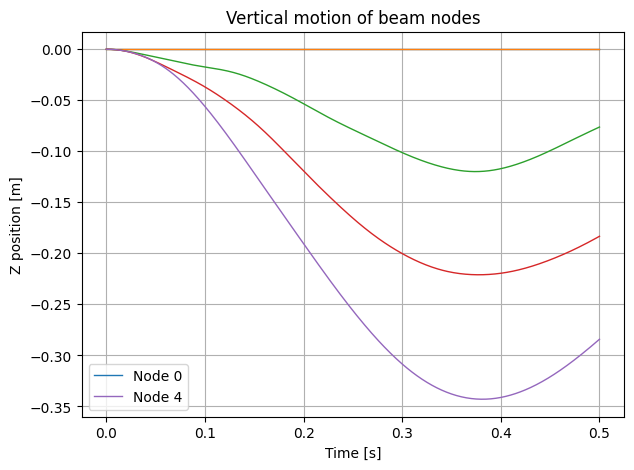

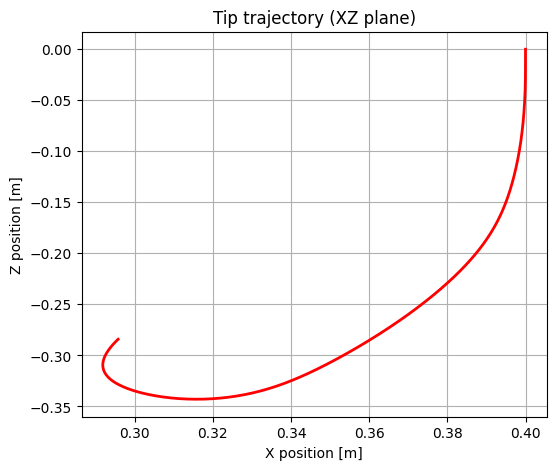

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Convert trajectory to numpy
q_traj_np = q_traj.detach().cpu().numpy().reshape(len(t), num_nodes, 3)
t_np = t.detach().cpu().numpy()

# Plot Z-displacement (vertical motion) of each node
plt.figure(figsize=(7, 5))
for i in range(num_nodes):
    plt.plot(t_np, q_traj_np[:, i, 2], label=f'Node {i}' if i in [0, num_nodes-1] else "", lw=1)
plt.xlabel("Time [s]")
plt.ylabel("Z position [m]")
plt.title("Vertical motion of beam nodes")
plt.legend()
plt.grid(True)
plt.show()

# Plot trajectory of beam tip (last node)
plt.figure(figsize=(6, 5))
plt.plot(q_traj_np[:, -1, 0], q_traj_np[:, -1, 2], 'r-', lw=2)
plt.xlabel("X position [m]")
plt.ylabel("Z position [m]")
plt.title("Tip trajectory (XZ plane)")
plt.grid(True)
plt.show()


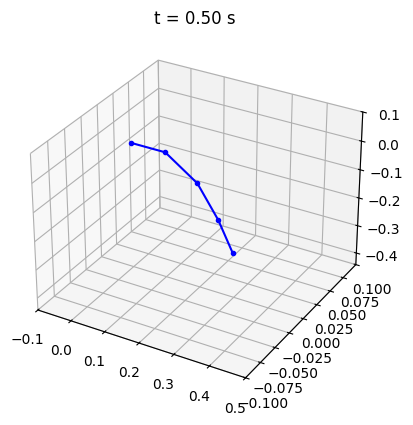

In [20]:
import matplotlib.animation as animation

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def update(frame):
    ax.cla()
    ax.plot(q_traj_np[frame, :, 0],
            q_traj_np[frame, :, 1],
            q_traj_np[frame, :, 2],
            'b.-')
    ax.set_xlim([q_traj_np[:, :, 0].min()-0.1, q_traj_np[:, :, 0].max()+0.1])
    ax.set_ylim([q_traj_np[:, :, 1].min()-0.1, q_traj_np[:, :, 1].max()+0.1])
    ax.set_zlim([q_traj_np[:, :, 2].min()-0.1, q_traj_np[:, :, 2].max()+0.1])
    ax.set_title(f"t = {t[frame]:.2f} s")
    return ax

ani = animation.FuncAnimation(fig, update, frames=range(0, len(t), 10), interval=50)
ani.save("learned_stretch_bend_springs.gif", writer="ffmpeg", fps=20)
plt.show()
